In [1]:
%%bash

pip install -q kaggle
mkdir -p ~/.kaggle
cp drive/MyDrive/kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d techsash/waste-classification-data
unzip -qq waste-classification-data.zip

100%|██████████| 427M/427M [00:02<00:00, 169MB/s]


# Waste Classification



## Importing required libraries

In [4]:
import numpy as np
from tensorflow import keras 
import tensorflow as tf
import PIL
import PIL.Image
import os
import pathlib

## Pre-Processing

In [6]:
data_dir = pathlib.Path("DATASET/TRAIN/").with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

22564

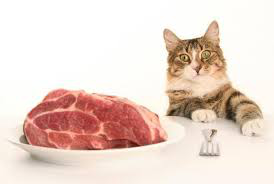

In [8]:
non_dust = list(data_dir.glob("O/*"))
PIL.Image.open(str(non_dust[0]))

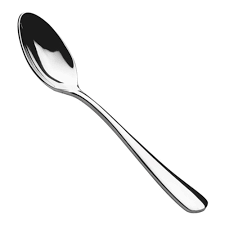

In [9]:
dust = list(data_dir.glob("R/*"))
PIL.Image.open(str(dust[4]))

In [10]:
batch_size = 32
img_height = 120
img_width = 120

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 22564 files belonging to 2 classes.
Using 18052 files for training.
Found 22564 files belonging to 2 classes.
Using 4512 files for validation.


In [13]:
class_names = train_ds.class_names
class_names

['O', 'R']

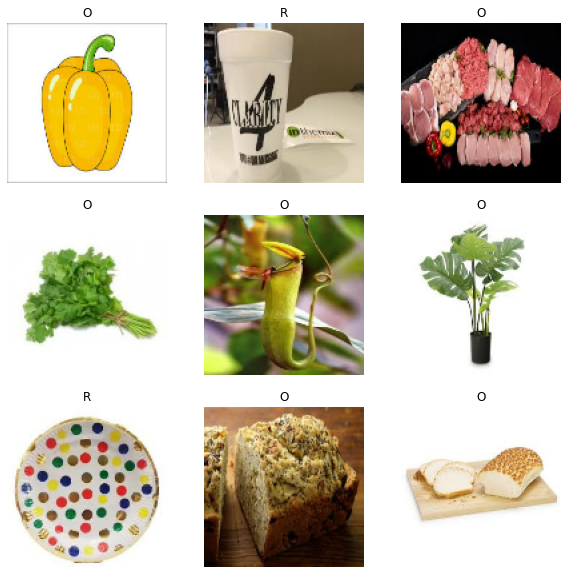

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 120, 120, 3)
(32,)


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


9.188933e-05 1.0


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [21]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [22]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=3
)


Epoch 1/3
565/565 [==============================] - 494s 862ms/step - loss: 0.4290 - accuracy: 0.8142 - val_loss: 0.4275 - val_accuracy: 0.8118
Epoch 2/3
565/565 [==============================] - 408s 723ms/step - loss: 0.3729 - accuracy: 0.8410 - val_loss: 0.3465 - val_accuracy: 0.8595
Epoch 3/3
565/565 [==============================] - 423s 750ms/step - loss: 0.3400 - accuracy: 0.8558 - val_loss: 0.3323 - val_accuracy: 0.8655
